In [87]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np

In [88]:
dataset_path =r'E:\work\masters\Trento\Academics\Semesters\Year 1 Semester 1\146069 Next Generation Networks\project\execution\data\Data\RTT_data.csv' 

In [89]:
RTT_data= pd.read_csv(dataset_path)

In [90]:
selected_row = 40
selected_data = RTT_data.iloc[selected_row] 

channels_begin = 11
channel_batch_size =114
channels_unpadded = selected_data[channels_begin:channels_begin+2*channel_batch_size]  
channels_unpadded 

channel_side1_ant1_tone  1     44+46i
channel_side1_ant1_tone  2     57+41i
channel_side1_ant1_tone  3     75+26i
channel_side1_ant1_tone  4         84
channel_side1_ant1_tone  5     84-34i
                               ...   
channel_side1_ant2_tone110    -15-11i
channel_side1_ant2_tone111    -18-10i
channel_side1_ant2_tone112     -22-7i
channel_side1_ant2_tone113     -26-1i
channel_side1_ant2_tone114     -30+6i
Name: 40, Length: 228, dtype: object

In [91]:
np_channels = np.array(channels_unpadded)

np_channels_cplx = np.zeros_like(np_channels)

counter = 0
for ch_rsp in np_channels:
    ch_rsp= complex(ch_rsp.replace('i', 'j')) 
    np_channels_cplx[counter] = ch_rsp 
    counter+=1

channels_unpadded_raw = np_channels_cplx
# Add 3 DC tones and guard subcarriers for 40MHz Wi-Fi
sub_channel_batch_size = 57

zeros_to_pad = 28 
channels = np.zeros(2*channel_batch_size+28, dtype=complex)
current_index = 6 
channels[current_index:sub_channel_batch_size+current_index] = channels_unpadded_raw[:sub_channel_batch_size]
current_index += (sub_channel_batch_size +3)
channels[current_index:current_index+sub_channel_batch_size] = channels_unpadded_raw[sub_channel_batch_size:channel_batch_size]
current_index += (sub_channel_batch_size+11)
channels[current_index:current_index+sub_channel_batch_size] = channels_unpadded_raw[channel_batch_size:sub_channel_batch_size+channel_batch_size] 
current_index += (sub_channel_batch_size+3)
channels[current_index:current_index+sub_channel_batch_size] =  channels_unpadded_raw[sub_channel_batch_size+channel_batch_size:2*channel_batch_size]
channels.shape

channels_client = channels[:128]
channels_ap = channels[128:]

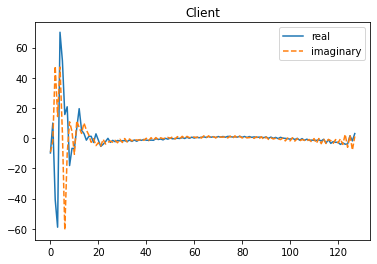

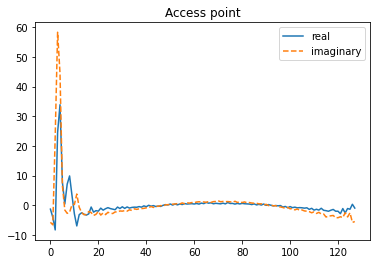

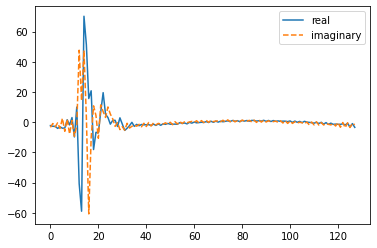

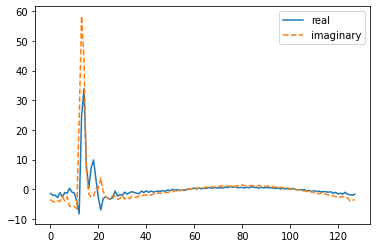

7.5e-08 7.5e-08
ToD factor 2.3987 estimated range 24.898699999999998 Ground truth range 23.051 range error 1.8476999999999997


In [94]:

channels_timedomain = np.fft.ifft(np.fft.ifftshift(channels_client))
channels_timedomain_ap = np.fft.ifft(np.fft.ifftshift(channels_ap))

plt.plot(channels_timedomain.real, label='real')
plt.plot(channels_timedomain.imag, '--',  label='imaginary')
plt.title('Client') 
plt.legend()
plt.show()

plt.plot(channels_timedomain_ap.real, label='real')
plt.plot(channels_timedomain_ap.imag, '--',  label='imaginary') 
plt.title('Access point')
plt.legend()
plt.show()

'''
plt.plot(np.abs(channels_timedomain))
plt.xlabel('Time index')
plt.ylabel('Channel Magnitude')
'''

N_samples_to_shift = 10; # integer number of samples to circular shift
channel_time_domain_circ_shifted = np.roll(channels_timedomain, N_samples_to_shift)
channel_time_domain_circ_shifted_ap = np.roll(channels_timedomain_ap, N_samples_to_shift)


plt.plot(channel_time_domain_circ_shifted.real, label='real')
plt.plot(channel_time_domain_circ_shifted.imag, '--',  label='imaginary') 
plt.legend()
plt.show()

plt.plot(channel_time_domain_circ_shifted_ap.real, label='real')
plt.plot(channel_time_domain_circ_shifted_ap.imag, '--',  label='imaginary') 
plt.legend()
plt.show()

est_ToA_index_client = np.argmax(channel_time_domain_circ_shifted)

est_ToA_index_AP = np.argmax(channel_time_domain_circ_shifted_ap)

#print(est_ToA_index_client,est_ToA_index_AP)
# Correct ToA indexes by -N_samples_to_shift
est_ToA_index_client    = est_ToA_index_client - N_samples_to_shift
est_ToA_index_AP        = est_ToA_index_AP - N_samples_to_shift

# Translate the sample index to time in seconds
# The channels are sampled at 40MHz. The entire symbol is 3.2usec length.
delta_time_per_sample = 1/40e6 # time difference between each two samples (sec)
est_ToA_client = (est_ToA_index_client - 1)*delta_time_per_sample  # estimated client ToA in seconds
est_ToA_AP     = (est_ToA_index_AP - 1)*delta_time_per_sample      # estimated AP ToA in seconds

print(est_ToA_client, est_ToA_AP)

# Calculate estimated range and range error
ToD_factor = selected_data['ToD_factor[m]'] # in meters RTT_data(:,ind.ToDfactor)
est_range = ToD_factor + (est_ToA_client + est_ToA_AP)*3e8/2 # estimated range [m]
GT_range = selected_data['GroundTruthRange[m]'] # ground truth range for this measurement [m]
range_error = est_range - GT_range # estimated range error [m] 
print('ToD factor',ToD_factor,'estimated range',est_range,'Ground truth range', GT_range, 'range error', range_error)


In [73]:
# Range bias, a cummulative probability distribution 